# Lab-5.1: Python GeoPandas & Folium

**Author**: Amit Arora

**Instructions** 

**Demonstration section:** The instructors will work through this section during the lab period. It is meant to be educational, with various code examples provided for you. You should understand all code in the demonstration section and should run the cells on your local machine before attempting the assignment

**Download**: ![Click here](lab-5.1.ipynb.zip) to download the notebook to follow along

**Submission:** No lab assignment this week, use the time to work on your projects. 

**NOTE**: It is recommended that you complete this `.ipynb` file in VS Code. Activate the `anly503` environment by selecting the kernel in the upper-right corner of VS-code. 

## Demonstration

Before starting the assignment, lets work through the various sub-components needed.

### Import

Install the `folium` package.

In [1]:
#!pip install folium==0.14.0 geopy==2.3.0 geopandas==0.12.2

In [2]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from folium.plugins import HeatMapWithTime

### Data

In [3]:
# Load the dataset
df = pd.read_parquet('https://bigdatateaching.s3.amazonaws.com/nyc-taxi-2016/nyc_taxi_2016.parquet')

## Exploratory Data Analysis



Let us get the shape of the dataframe to see the size of the data we are dealing with.


In [4]:
print(f"shape of the dataframe is {df.shape[0]:,}x{df.shape[1]}")

shape of the dataframe is 1,458,644x11


Note the `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` columns, these are the columns we would be using for plotting this dataset on a map.

In [5]:
## Down-sample (optional)
df=df.sample(frac=0.035)

print(f"shape of the dataframe is {df.shape[0]:,}x{df.shape[1]}")

shape of the dataframe is 51,053x11


In [6]:
# Preview the dataset
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
1296810  id2308975          1  2016-04-08 17:00:21  2016-04-08 17:10:50   
941995   id3188796          1  2016-05-10 14:05:27  2016-05-10 14:46:05   
271778   id1244425          2  2016-04-08 06:46:11  2016-04-08 07:02:01   
664393   id1640582          2  2016-01-20 15:01:17  2016-01-20 15:47:25   
802104   id2166356          1  2016-01-01 01:55:00  2016-01-01 02:07:32   

         passenger_count  pickup_longitude  pickup_latitude  \
1296810                1        -73.934502        40.757019   
941995                 1        -73.991524        40.726341   
271778                 1        -73.987923        40.759655   
664393                 2        -73.781960        40.644642   
802104                 1        -73.951927        40.715782   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
1296810         -73.918777         40.742851                  N            629  
941995          -73.983360         40.775219                  N           2438  
271778          -73.935410         40.847439                  N            950  
664393          -73.947227         40.801079                  N           2768  
802104          -73.921219         40.708237                  N            752

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51053 entries, 1296810 to 673987
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  51053 non-null  object 
 1   vendor_id           51053 non-null  int64  
 2   pickup_datetime     51053 non-null  object 
 3   dropoff_datetime    51053 non-null  object 
 4   passenger_count     51053 non-null  int64  
 5   pickup_longitude    51053 non-null  float64
 6   pickup_latitude     51053 non-null  float64
 7   dropoff_longitude   51053 non-null  float64
 8   dropoff_latitude    51053 non-null  float64
 9   store_and_fwd_flag  51053 non-null  object 
 10  trip_duration       51053 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 4.7+ MB


### GeoPandas

Let us first explore the dataset with `GeoPandas`. We start with plotting the pickup and dropoff locations as a simple scatter plot using `matplotlib`. Notice that these plots automatically resemble the shape of New York City.

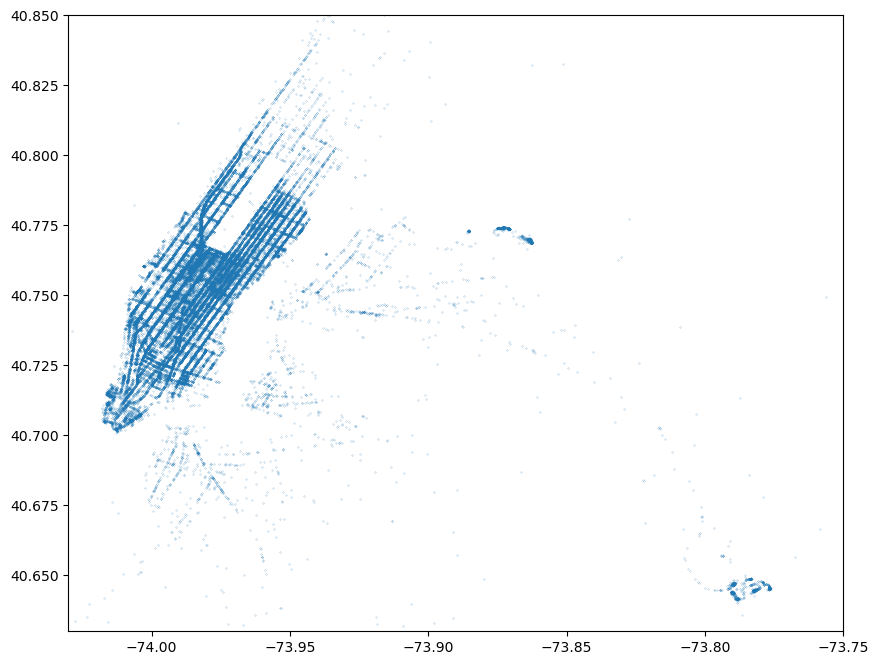

In [8]:
# visualizing passenger pickup locations
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(df['pickup_longitude'],df['pickup_latitude'], s=0.02, alpha=1)

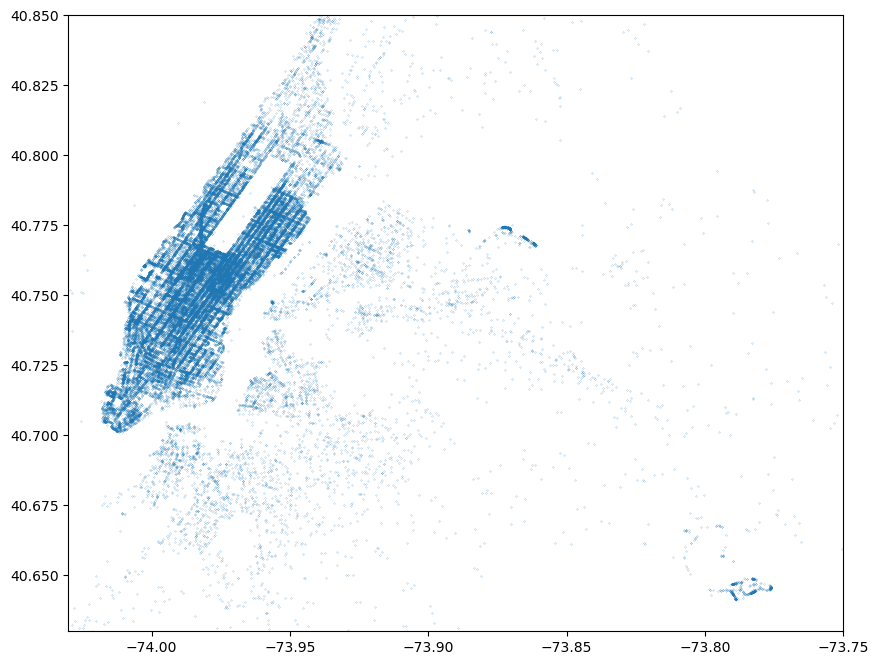

In [9]:
# visualizing passenger dropoff locations
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(df['dropoff_longitude'],df['dropoff_latitude'], s=0.02, alpha=1)

Now let us use `GeoPandas` to plot the New York City burroughs, this is easy because `GeoPandas` comes with the `nybb` dataset that has the geometry/shape information to do this.

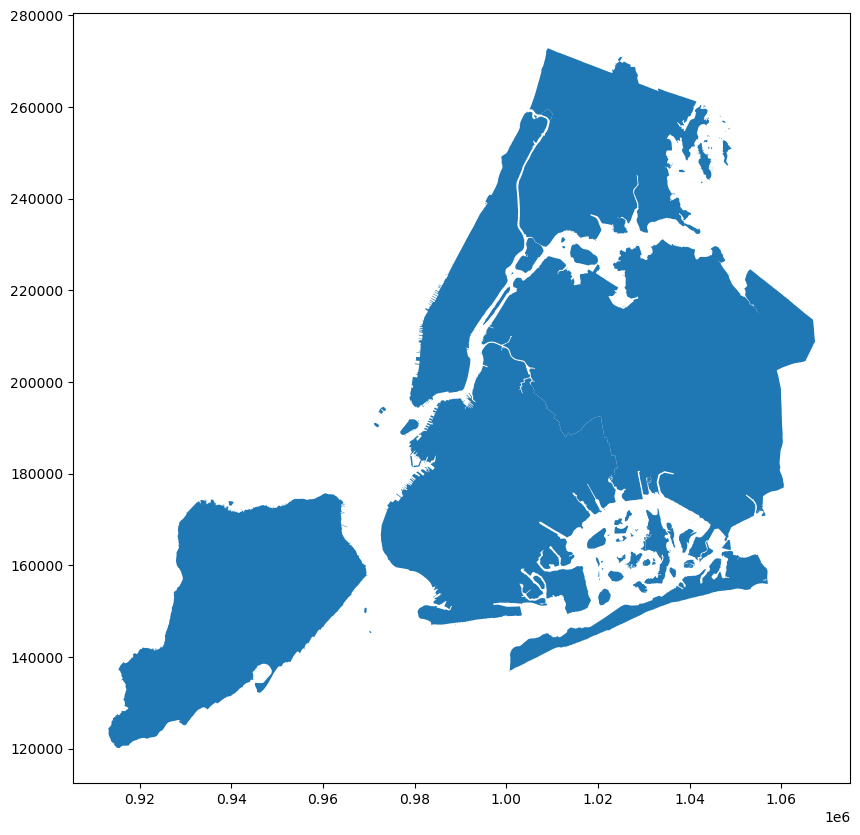

In [10]:
# getting New York City map from Geopandas
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(12, 10))

We can do this better by using the shape files available from `https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile` in the form of a single zip file. The zip file actually contains 4 files and we need all 4 of them. To make things easier, the 4 files have already been downloaded and made available in the [datasets](https://github.com/anly503/datasets) repo so here we are just going to download these files from there.

In [11]:
import requests
import os

shape_files = ['https://github.com/anly503/datasets/raw/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.shp',
               'https://github.com/anly503/datasets/raw/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.dbf',
               'https://raw.githubusercontent.com/anly503/datasets/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.prj',
               'https://github.com/anly503/datasets/raw/main/nyc-shape-files/geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.shx']

for f in shape_files:
    r = requests.get(f, allow_redirects=True)
    open(os.path.basename(f), 'wb').write(r.content)

In [12]:
zones = gpd.read_file('geo_export_0c35ce5c-c15b-46b5-9303-1c5a64b2472d.shp').to_crs({'init' :'epsg:4326'})
zones.head()

c:\Users\Dan Lim\miniconda3\envs\ANLY503\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


borough  location_i  objectid  shape_area  shape_leng  \
0            EWR         1.0       1.0    0.000782    0.116357   
1         Queens         2.0       2.0    0.004866    0.433470   
2          Bronx         3.0       3.0    0.000314    0.084341   
3      Manhattan         4.0       4.0    0.000112    0.043567   
4  Staten Island         5.0       5.0    0.000498    0.092146   

                      zone                                           geometry  
0           Newark Airport  POLYGON ((-74.18445 40.69500, -74.18449 40.695...  
1              Jamaica Bay  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2  Allerton/Pelham Gardens  POLYGON ((-73.84793 40.87134, -73.84725 40.870...  
3            Alphabet City  POLYGON ((-73.97177 40.72582, -73.97179 40.725...  
4            Arden Heights  POLYGON ((-74.17422 40.56257, -74.17349 40.562...

Now plot the map and colorize by boroughs.

<AxesSubplot: >

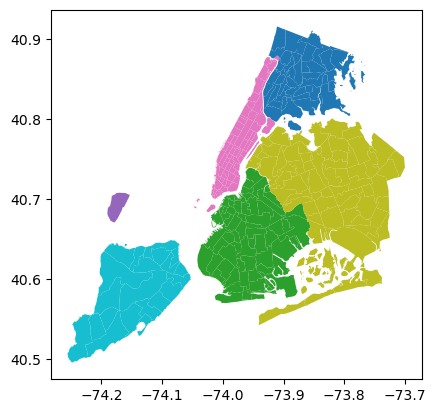

In [13]:
zones.plot(column='borough', categorical=True)

#### Find out the zones and boroughs that form the most common pickup and dropoff locations

To do this, we will convert our Pandas dataframe into a `GeoPandas` dataframe (see [this](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) link) and then join it with the zones dataframe so that for each trip (row of the dataframe) we have the pickup and dropoff zone and borough. 

1. We have to do this in two steps, once for the pickup location and once for the dropoff locations because a geopandas dataframe can have a single geometry column at a time.

1. We will join the geopandas dataframe with the zones dataframe using [`sjoin`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) and we use the predicate `within` to say that if a pickup/dropoff location is within the polygon of a zones dataframe row then that is when the join happens.

In [14]:
geo_df_pu = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude), crs={'init' :'epsg:4326'})
geo_df_pu.head()

c:\Users\Dan Lim\miniconda3\envs\ANLY503\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id  vendor_id      pickup_datetime     dropoff_datetime  \
1296810  id2308975          1  2016-04-08 17:00:21  2016-04-08 17:10:50   
941995   id3188796          1  2016-05-10 14:05:27  2016-05-10 14:46:05   
271778   id1244425          2  2016-04-08 06:46:11  2016-04-08 07:02:01   
664393   id1640582          2  2016-01-20 15:01:17  2016-01-20 15:47:25   
802104   id2166356          1  2016-01-01 01:55:00  2016-01-01 02:07:32   

         passenger_count  pickup_longitude  pickup_latitude  \
1296810                1        -73.934502        40.757019   
941995                 1        -73.991524        40.726341   
271778                 1        -73.987923        40.759655   
664393                 2        -73.781960        40.644642   
802104                 1        -73.951927        40.715782   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1296810         -73.918777         40.742851                  N   
941995          -73.983360         40.775219                  N   
271778          -73.935410         40.847439                  N   
664393          -73.947227         40.801079                  N   
802104          -73.921219         40.708237                  N   

         trip_duration                    geometry  
1296810            629  POINT (-73.93450 40.75702)  
941995            2438  POINT (-73.99152 40.72634)  
271778             950  POINT (-73.98792 40.75965)  
664393            2768  POINT (-73.78196 40.64464)  
802104             752  POINT (-73.95193 40.71578)

In [15]:
geo_df_pu = gpd.sjoin(geo_df_pu, zones[['zone', 'borough', 'geometry']], how="left", predicate="within")

geo_df_pu.drop(['geometry', 'index_right'], axis=1, inplace=True)
geo_df_pu.rename({"zone": "zone_pu", "borough": "borough_pu"}, axis=1, inplace=True)

geo_df_pu.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
1296810  id2308975          1  2016-04-08 17:00:21  2016-04-08 17:10:50   
941995   id3188796          1  2016-05-10 14:05:27  2016-05-10 14:46:05   
271778   id1244425          2  2016-04-08 06:46:11  2016-04-08 07:02:01   
664393   id1640582          2  2016-01-20 15:01:17  2016-01-20 15:47:25   
802104   id2166356          1  2016-01-01 01:55:00  2016-01-01 02:07:32   

         passenger_count  pickup_longitude  pickup_latitude  \
1296810                1        -73.934502        40.757019   
941995                 1        -73.991524        40.726341   
271778                 1        -73.987923        40.759655   
664393                 2        -73.781960        40.644642   
802104                 1        -73.951927        40.715782   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1296810         -73.918777         40.742851                  N   
941995          -73.983360         40.775219                  N   
271778          -73.935410         40.847439                  N   
664393          -73.947227         40.801079                  N   
802104          -73.921219         40.708237                  N   

         trip_duration                        zone_pu borough_pu  
1296810            629  Long Island City/Queens Plaza     Queens  
941995            2438                   East Village  Manhattan  
271778             950      Times Sq/Theatre District  Manhattan  
664393            2768                    JFK Airport     Queens  
802104             752      Williamsburg (North Side)   Brooklyn

In [16]:
geo_df_do = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude), crs={'init' :'epsg:4326'})
geo_df_do.head()

c:\Users\Dan Lim\miniconda3\envs\ANLY503\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id  vendor_id      pickup_datetime     dropoff_datetime  \
1296810  id2308975          1  2016-04-08 17:00:21  2016-04-08 17:10:50   
941995   id3188796          1  2016-05-10 14:05:27  2016-05-10 14:46:05   
271778   id1244425          2  2016-04-08 06:46:11  2016-04-08 07:02:01   
664393   id1640582          2  2016-01-20 15:01:17  2016-01-20 15:47:25   
802104   id2166356          1  2016-01-01 01:55:00  2016-01-01 02:07:32   

         passenger_count  pickup_longitude  pickup_latitude  \
1296810                1        -73.934502        40.757019   
941995                 1        -73.991524        40.726341   
271778                 1        -73.987923        40.759655   
664393                 2        -73.781960        40.644642   
802104                 1        -73.951927        40.715782   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1296810         -73.918777         40.742851                  N   
941995          -73.983360         40.775219                  N   
271778          -73.935410         40.847439                  N   
664393          -73.947227         40.801079                  N   
802104          -73.921219         40.708237                  N   

         trip_duration                    geometry  
1296810            629  POINT (-73.91878 40.74285)  
941995            2438  POINT (-73.98336 40.77522)  
271778             950  POINT (-73.93541 40.84744)  
664393            2768  POINT (-73.94723 40.80108)  
802104             752  POINT (-73.92122 40.70824)

In [17]:
geo_df_do = gpd.sjoin(geo_df_do, zones[['zone', 'borough', 'geometry']], how="left", predicate="within")

geo_df_do.drop(['geometry', 'index_right'], axis=1, inplace=True)
geo_df_do.rename({"zone": "zone_do", "borough": "borough_do"}, axis=1, inplace=True)

geo_df_do.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
1296810  id2308975          1  2016-04-08 17:00:21  2016-04-08 17:10:50   
941995   id3188796          1  2016-05-10 14:05:27  2016-05-10 14:46:05   
271778   id1244425          2  2016-04-08 06:46:11  2016-04-08 07:02:01   
664393   id1640582          2  2016-01-20 15:01:17  2016-01-20 15:47:25   
802104   id2166356          1  2016-01-01 01:55:00  2016-01-01 02:07:32   

         passenger_count  pickup_longitude  pickup_latitude  \
1296810                1        -73.934502        40.757019   
941995                 1        -73.991524        40.726341   
271778                 1        -73.987923        40.759655   
664393                 2        -73.781960        40.644642   
802104                 1        -73.951927        40.715782   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1296810         -73.918777         40.742851                  N   
941995          -73.983360         40.775219                  N   
271778          -73.935410         40.847439                  N   
664393          -73.947227         40.801079                  N   
802104          -73.921219         40.708237                  N   

         trip_duration                   zone_do borough_do  
1296810            629                 Sunnyside     Queens  
941995            2438       Lincoln Square East  Manhattan  
271778             950  Washington Heights South  Manhattan  
664393            2768            Central Harlem  Manhattan  
802104             752            Bushwick North   Brooklyn

Now we will combine the pickup and dropoff dataframes so that we have the zone and borough for both pickup and dropoff locations.

In [18]:
gdf_pu_do = pd.merge(geo_df_do, geo_df_pu, how="inner")
gdf_pu_do

id  vendor_id      pickup_datetime     dropoff_datetime  \
0      id2308975          1  2016-04-08 17:00:21  2016-04-08 17:10:50   
1      id3188796          1  2016-05-10 14:05:27  2016-05-10 14:46:05   
2      id1244425          2  2016-04-08 06:46:11  2016-04-08 07:02:01   
3      id1640582          2  2016-01-20 15:01:17  2016-01-20 15:47:25   
4      id2166356          1  2016-01-01 01:55:00  2016-01-01 02:07:32   
...          ...        ...                  ...                  ...   
51048  id0561616          1  2016-01-22 13:26:56  2016-01-22 13:44:47   
51049  id3604669          1  2016-05-23 19:36:01  2016-05-23 19:41:33   
51050  id3796553          2  2016-02-19 16:27:42  2016-02-19 16:42:14   
51051  id0363819          1  2016-06-14 13:07:20  2016-06-14 13:41:33   
51052  id2516994          2  2016-02-28 01:33:12  2016-02-28 01:44:34   

       passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                    1        -73.934502        40.757019         -73.918777   
1                    1        -73.991524        40.726341         -73.983360   
2                    1        -73.987923        40.759655         -73.935410   
3                    2        -73.781960        40.644642         -73.947227   
4                    1        -73.951927        40.715782         -73.921219   
...                ...               ...              ...                ...   
51048                2        -73.956612        40.687721         -73.928345   
51049                1        -74.007668        40.726311         -74.014877   
51050                3        -73.967567        40.763355         -73.981819   
51051                2        -73.997444        40.722412         -73.979073   
51052                2        -73.991684        40.727051         -73.986427   

       dropoff_latitude store_and_fwd_flag  trip_duration  \
0             40.742851                  N            629   
1             40.775219                  N           2438   
2             40.847439                  N            950   
3             40.801079                  N           2768   
4             40.708237                  N            752   
...                 ...                ...            ...   
51048         40.668842                  N           1071   
51049         40.716644                  N            332   
51050         40.756714                  N            872   
51051         40.777412                  N           2053   
51052         40.751755                  N            682   

                        zone_do borough_do                        zone_pu  \
0                     Sunnyside     Queens  Long Island City/Queens Plaza   
1           Lincoln Square East  Manhattan                   East Village   
2      Washington Heights South  Manhattan      Times Sq/Theatre District   
3                Central Harlem  Manhattan                    JFK Airport   
4                Bushwick North   Brooklyn      Williamsburg (North Side)   
...                         ...        ...                            ...   
51048       Crown Heights North   Brooklyn                        Bedford   
51049         Battery Park City  Manhattan                      Hudson Sq   
51050            Midtown Center  Manhattan          Upper East Side South   
51051       Lincoln Square East  Manhattan            Little Italy/NoLiTa   
51052          Garment District  Manhattan        Greenwich Village South   

      borough_pu  
0         Queens  
1      Manhattan  
2      Manhattan  
3         Queens  
4       Brooklyn  
...          ...  
51048   Brooklyn  
51049  Manhattan  
51050  Manhattan  
51051  Manhattan  
51052  Manhattan  

[51053 rows x 15 columns]

Counts for pickup and droppoff locations considering both zone and borough. This is a long tailed distribution as even the most frequently occuring combination only accounts of 0.5% of the total trips.

In [19]:
gdf_pu_do.value_counts(["zone_pu", "borough_pu", "zone_do", "borough_do"], normalize=True).mul(100).reset_index(name="trips")

zone_pu borough_pu                zone_do  \
0              Upper East Side South  Manhattan  Upper East Side North   
1              Upper East Side North  Manhattan  Upper East Side North   
2              Upper East Side North  Manhattan  Upper East Side South   
3              Upper East Side South  Manhattan  Upper East Side South   
4              Upper West Side South  Manhattan    Lincoln Square East   
...                              ...        ...                    ...   
5862                        Gramercy  Manhattan         Bushwick South   
5863                 Jamaica Estates     Queens      Hillcrest/Pomonok   
5864                        Gramercy  Manhattan           Clinton Hill   
5865  Stuy Town/Peter Cooper Village  Manhattan                 Inwood   
5866                    Clinton West  Manhattan            Marble Hill   

     borough_do     trips  
0     Manhattan  0.506667  
1     Manhattan  0.467391  
2     Manhattan  0.443825  
3     Manhattan  0.404548  
4     Manhattan  0.257261  
...         ...       ...  
5862   Brooklyn  0.001964  
5863     Queens  0.001964  
5864   Brooklyn  0.001964  
5865  Manhattan  0.001964  
5866  Manhattan  0.001964  

[5867 rows x 5 columns]

Counts for pickup and droppoff locations considering only the borough. This is interesting because **87% of the trips start and end in Manhattan**.

In [20]:
gdf_pu_do_borough = gdf_pu_do.value_counts(["borough_pu", "borough_do"], normalize=True).mul(100).reset_index(name="trips")
gdf_pu_do_borough["pu_do"] = gdf_pu_do_borough["borough_pu"] + " to " + gdf_pu_do_borough["borough_do"]
gdf_pu_do_borough

borough_pu     borough_do      trips                           pu_do
0       Manhattan      Manhattan  84.582000          Manhattan to Manhattan
1       Manhattan         Queens   3.532924             Manhattan to Queens
2          Queens      Manhattan   3.375817             Queens to Manhattan
3       Manhattan       Brooklyn   3.354215           Manhattan to Brooklyn
4          Queens         Queens   1.620157                Queens to Queens
5        Brooklyn       Brooklyn   1.233283            Brooklyn to Brooklyn
6          Queens       Brooklyn   0.850337              Queens to Brooklyn
7       Manhattan          Bronx   0.528269              Manhattan to Bronx
8        Brooklyn      Manhattan   0.449716           Brooklyn to Manhattan
9       Manhattan            EWR   0.155142                Manhattan to EWR
10         Queens          Bronx   0.108010                 Queens to Bronx
11       Brooklyn         Queens   0.104083              Brooklyn to Queens
12          Bronx          Bronx   0.051059                  Bronx to Bronx
13          Bronx      Manhattan   0.021602              Bronx to Manhattan
14      Manhattan  Staten Island   0.009819      Manhattan to Staten Island
15            EWR            EWR   0.009819                      EWR to EWR
16       Brooklyn          Bronx   0.003928               Brooklyn to Bronx
17         Queens  Staten Island   0.003928         Queens to Staten Island
18            EWR         Queens   0.001964                   EWR to Queens
19         Queens            EWR   0.001964                   Queens to EWR
20  Staten Island  Staten Island   0.001964  Staten Island to Staten Island

In [21]:

import plotly.express as px

fig = px.bar(gdf_pu_do_borough, x="pu_do", y="trips")
fig.show()

### Folium

We will start with a base map of New York City and then add a subset of the data (trips) to the map.

In [33]:
default_location = [40.693943, -73.985880]
default_zoom_start = 11
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
base_map

Now lets add some trip data to the map, because there are close to 1.5 million trip, we will plot only a very small fraction of those. There are other techniques to use when plotting so many data points on a map.

In [34]:
# Add markers for pickups and dropoffs
frac = 0.0001
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
for index, row in df.sample(frac=frac).iterrows():
    folium.Marker([row['pickup_latitude'],
                   row['pickup_longitude']],
                   icon=folium.Icon(color='blue'),
                   tooltip=f'{row["id"]}').add_to(base_map)
    folium.Marker([row['dropoff_latitude'],
                   row['dropoff_longitude']],
                   icon=folium.Icon(color='red'),
                   tooltip=f'{row["id"]}').add_to(base_map)
base_map

Clearly, there are too many markers on this plot for it to be useful, even with the tooltip (and we can add more information to the tooltip). Folium also provides the option of creating a `MarkerCluster` where a bunch of markers that are close by get grouped together and then we can zoom in to see individual markers.

More details on `MarkerCluster` is available on the Leaflet GitHub page for [cluster methods](https://github.com/Leaflet/Leaflet.markercluster/blob/master/README.md#clusters-methods). Customization of `MarkerCluster` may require some JavaScript, see [this](https://stackoverflow.com/questions/72222835/folium-put-markers-in-marker-clusters-and-in-layers-based-on-a-value), [this](https://stackoverflow.com/questions/24258914/leaflet-clustermarker-with-custom-icon) and [this](https://stackoverflow.com/questions/52428916/python-folium-markercluster-color-customization) StackOverflow posts.

In [24]:
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)

# create a marker cluster called "NYC Trips"
marker_cluster = MarkerCluster().add_to(base_map)
for index, row in df.sample(frac=frac).iterrows():
    folium.Marker([row['pickup_latitude'],
                   row['pickup_longitude']],
                   icon=folium.Icon(color='blue'),
                   tooltip=f'{row["id"]}').add_to(marker_cluster)
    folium.Marker([row['dropoff_latitude'],
                   row['dropoff_longitude']],
                   icon=folium.Icon(color='red'),
                   tooltip=f'{row["id"]}').add_to(marker_cluster)
base_map

A Heatmap is a good option for exploring the density of where the pickups and droppoffs are located. We will make a heatmap for the pickup locations next. The folium `HeatMap` function does that for us. The `Heatmap` function requires a `list` in the following format `[[lat, lng, count], [lat, lng, count],...,[lat, lng, count]]`.

In [25]:
df_pickup_location_counts = df.value_counts(['pickup_latitude', 'pickup_longitude']).reset_index(name='counts')

base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
HeatMap(data=df_pickup_location_counts.values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

Ok, now it would be interesting to visualize the most common pickup and dropoff points combination. We have to handle to problems before we can do that:

1. A lot of the trips have the same pickup and dropoff latitude and longitude, probably because the trips got cancelled or maybe problems with the data, so we need to exclude those.

1. Maybe the exact location in terms of latitude and longitude for different trips may not be the same but they are probably in the same general area, so we should count them as one location for the purpose of finding the most common pickup and dropoff points combination. To do this, we convert the latitude and longitude to a coarse version by just rounding them off to 2 or 3 decimal places. 

In [26]:
location_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
location_coarse_cols = [c + "_coarse" for c in location_cols]
df_trips_that_happened = df[(df.pickup_longitude != df.dropoff_longitude) & (df.pickup_latitude != df.dropoff_latitude)]
for loc_col, loc_coarse_col in zip(location_cols, location_coarse_cols):
    df_trips_that_happened[loc_coarse_col] = round(df_trips_that_happened[loc_col], 2)
df_trips_that_happened.head()

C:\Users\Dan Lim\AppData\Local\Temp\ipykernel_14092\2537938070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Dan Lim\AppData\Local\Temp\ipykernel_14092\2537938070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Dan Lim\AppData\Local\Temp\ipykernel_14092\2537938070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

id  vendor_id      pickup_datetime     dropoff_datetime  \
1296810  id2308975          1  2016-04-08 17:00:21  2016-04-08 17:10:50   
941995   id3188796          1  2016-05-10 14:05:27  2016-05-10 14:46:05   
271778   id1244425          2  2016-04-08 06:46:11  2016-04-08 07:02:01   
664393   id1640582          2  2016-01-20 15:01:17  2016-01-20 15:47:25   
802104   id2166356          1  2016-01-01 01:55:00  2016-01-01 02:07:32   

         passenger_count  pickup_longitude  pickup_latitude  \
1296810                1        -73.934502        40.757019   
941995                 1        -73.991524        40.726341   
271778                 1        -73.987923        40.759655   
664393                 2        -73.781960        40.644642   
802104                 1        -73.951927        40.715782   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
1296810         -73.918777         40.742851                  N   
941995          -73.983360         40.775219                  N   
271778          -73.935410         40.847439                  N   
664393          -73.947227         40.801079                  N   
802104          -73.921219         40.708237                  N   

         trip_duration                    geometry  pickup_latitude_coarse  \
1296810            629  POINT (-73.91878 40.74285)                   40.76   
941995            2438  POINT (-73.98336 40.77522)                   40.73   
271778             950  POINT (-73.93541 40.84744)                   40.76   
664393            2768  POINT (-73.94723 40.80108)                   40.64   
802104             752  POINT (-73.92122 40.70824)                   40.72   

         pickup_longitude_coarse  dropoff_latitude_coarse  \
1296810                   -73.93                    40.74   
941995                    -73.99                    40.78   
271778                    -73.99                    40.85   
664393                    -73.78                    40.80   
802104                    -73.95                    40.71   

         dropoff_longitude_coarse  
1296810                    -73.92  
941995                     -73.98  
271778                     -73.94  
664393                     -73.95  
802104                     -73.92

Now that we have the coarse location, lets do a value count to find most frequently occuring pickup and dropoff combinations.

In [27]:
df_pickup_dropoff_location_counts = df_trips_that_happened.value_counts(location_coarse_cols).reset_index(name='counts')
df_pickup_dropoff_location_counts

pickup_latitude_coarse  pickup_longitude_coarse  \
0                      40.76                   -73.97   
1                      40.75                   -73.99   
2                      40.76                   -73.98   
3                      40.77                   -73.96   
4                      40.76                   -73.97   
...                      ...                      ...   
7158                   40.74                   -73.99   
7159                   40.74                   -73.99   
7160                   40.74                   -73.99   
7161                   40.74                   -73.99   
7162                   41.00                   -73.80   

      dropoff_latitude_coarse  dropoff_longitude_coarse  counts  
0                       40.77                    -73.96     287  
1                       40.76                    -73.98     267  
2                       40.75                    -73.99     253  
3                       40.76                    -73.97     227  
4                       40.75                    -73.98     226  
...                       ...                       ...     ...  
7158                    40.65                    -74.00       1  
7159                    40.65                    -74.01       1  
7160                    40.64                    -74.00       1  
7161                    40.63                    -73.93       1  
7162                    41.00                    -73.80       1  

[7163 rows x 5 columns]

Now just one more step before we put the markers on our `HeatMap` for the most common pickup and dropoff combinations. We would like to identify these locations by name so that they make a lot more sense to us than just plain old latitude longitude numbers. We do this using the `geopy` package as shown in the code below.

In [28]:
pu_lat = df_pickup_dropoff_location_counts.iloc[0]['pickup_latitude_coarse']
pu_lng = df_pickup_dropoff_location_counts.iloc[0]['pickup_longitude_coarse']
do_lat = df_pickup_dropoff_location_counts.iloc[0]['dropoff_latitude_coarse']
do_lng = df_pickup_dropoff_location_counts.iloc[0]['dropoff_longitude_coarse']

# Initialize Nominatim API
geolocator = Nominatim(user_agent="lab-5.1")

# Get location with geocode
pu_location = geolocator.geocode(f"{pu_lat},{pu_lng}")
do_location = geolocator.geocode(f"{do_lat},{do_lng}")
 
# Display location
print(f"most common trip pickup and dropoff are pickup from \"{pu_location}\" and dropoff at \"{do_location}\"")

most common trip pickup and dropoff are pickup from "664, Lexington Avenue, Manhattan Community Board 5, Manhattan, New York County, City of New York, New York, 10022, United States" and dropoff at "Dallas BBQ, 1265, 3rd Avenue, Manhattan Community Board 8, Manhattan, New York County, City of New York, New York, 10021, United States"


All set to add the markers on the `HeatMap`.

In [29]:
folium.Marker([pu_lat, pu_lng], icon=folium.Icon(color='blue'), tooltip=f'Pickup from {pu_location[:20]}').add_to(base_map)
folium.Marker([do_lat, do_lng], icon=folium.Icon(color='red'), tooltip=f'Dropoff at {do_location[:20]}').add_to(base_map)
base_map

Let's create one more map, this is a `HeatMap` that animates over time. Lets choose hour of day as our time scale.

In [30]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
df['hour'] = df.pickup_datetime.apply(lambda x: x.hour)

In [31]:
df['count'] = 1
df_hour_list = []
for hour in df.hour.sort_values().unique():
    df_hour_list.append(df.loc[df.hour == hour, ['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist())

In [32]:
base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## Lab Submission

There is no submission for this lab :).